In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
from torch.autograd import Variable 
import matplotlib.pyplot as plt 
import numpy as np 
import torch.nn.functional as F 

In [2]:
import seaborn as sns 
from torch import optim

In [3]:
import ignite 
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping 

### Скачиваем данные набора Fashion mnist 

In [4]:
needed_classes = [1, 4, 7]

In [5]:
def label_transform(x):
    """ Функция для кодирования классов"""
    if x in needed_classes:
        return needed_classes.index(x)
    return -1

In [6]:
train_data = torchvision.datasets.FashionMNIST("./data", download=True, 
                                              transform=transforms.Compose([transforms.ToTensor()]), 
                                              target_transform=label_transform)
test_data = torchvision.datasets.FashionMNIST("./data", download=True, train=False, 
                                             transform=transforms.Compose([transforms.ToTensor()]),
                                             target_transform=label_transform)  

### Сделаем выборку классов согласно варианту 

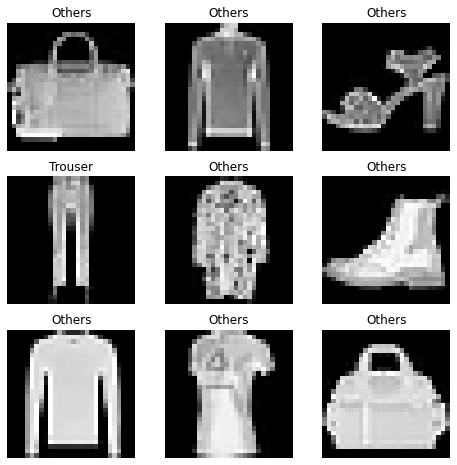

In [7]:
output_mapping = {
    0: "Trouser",
    1: "Coat",
    2: "Sneaker",
    -1: "Others",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(output_mapping[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
train_set_idx = [i for i, data in enumerate(train_data) if data[1] >= 0]
test_set_idx = [i for i, data in enumerate(test_data) if data[1] >= 0]
np.random.seed(4)
np.random.shuffle(train_set_idx)

In [9]:
valid_size = 0.3
split = int(np.floor(valid_size * len(train_set_idx)))
train_idx, valid_idx = train_set_idx[split:], train_set_idx[:split]

#### Разделим датасет на train, validation и test

In [10]:
train_set = torch.utils.data.Subset(train_data, train_idx)
valid_set = torch.utils.data.Subset(train_data, valid_idx)
test_set = torch.utils.data.Subset(test_data, test_set_idx)  

In [11]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64) 

### Визуализируем полученные данные 

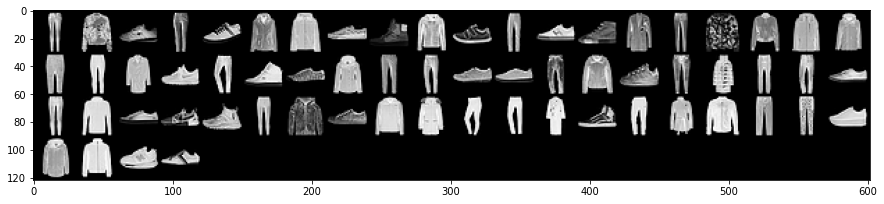

In [12]:
images, labels = next(iter(train_loader))

grid = torchvision.utils.make_grid(images, nrow=20)
plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid,(1,2,0)), cmap='gray') 

### Приступим к созданию нашего многослойного персетона

In [13]:
class EarlyStopping:
    """Класс реализующий технику раннней остановки для обученич инс"""
    def __init__(self, patience:int = 7, verbose:bool = False, delt:float = 0, 
                 path:str = 'checkpoint.pt', trace_func: def = print):
        """
        Args:
            patience  : кол-во эпох после которых, если loss не уменьшается, обучение прекращается   
            verbose   : условие вывода сообщения для каждого улучшения loss
            delta     : минимальное изменение в контролируемом количестве, 
                        чтобы квалифицироваться как улучшение
            path      : путь к файлу для сохранения модели 
            trace_func: функция трассировки печати     
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Метод сохраняет модель при уменьшении loss'''
        if self.verbose:
            self.trace_func(f'Значение loss на валидации уменьшилось ({self.val_loss_min:.6f} -->{val_loss:.6f}).')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [14]:
class Net(nn.Module):
    """ Класс многослойного персептрона"""
    def __init__(self):
        super(Net, self).__init__()
        self.layer_1 = nn.Sequential(
                       nn.Linear(28 * 28, 256),
                       nn.BatchNorm1d(256),
                       nn.ReLU())
        self.layer_2 = nn.Linear(256, 128)
        self.layer_3 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(0.25)
        self.softmax = nn.LogSoftmax(dim = 1) # логарифмическая вероятность в нейронной сети
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.layer_3(x)
        x = self.softmax(x)
        return x

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [36]:
# model_Adam = model_SGD = model_Momentum = Net()
model = Net()
print(model) 

Net(
  (layer_1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


In [38]:
criterion = nn.NLLLoss() # (negative) log-likelihood
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer_SGD = optim.SGD(model_SGD.parameters(), lr=learning_rate)
# optimizer_Momentum = torch.optim.SGD(model_Momentum.parameters(),lr=learning_rate, momentum=0.8)
# optimazer_RMSprop = torch.optim.RMSprop(model_Adam.parameters(), lr=learning_rate, alpha=0.9) 

### Обучим нашу нейронную сеть

In [18]:
def train_model(model, patience: int, n_epochs: int, optimizer):
    """ Функция обучения модели нейронной сети
    
    :param model   : модель для обучения
    :param patience: кол-во эпох после которых, если loss не уменьшается, обучение прекращается 
    :param n_epochs: кол-во эпох обучения
    :param optimizer: оптимизатор 
    
    :return model           : обученная модель
    :return avg_train_losses: массив средних значений loss для обучающей выборки
    :return avg_valid_losses: массив средних значений loss для валидационной выборки
    """
    train_losses = []
    valid_losses = []
    # среднее значение loss для обучающей выборки
    avg_train_losses = []
    # среднюю значение loss за эпоху по мере обучения модели
    avg_valid_losses = [] 
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):
        model.train() 
        for images, labels in train_loader:
            images = images.view(images.shape[0], -1)
#             optimizer.zero_grad()
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(loss.item())
            
        model.eval()
        for data, target in valid_loader:
            output = model(data)
            loss = criterion(output, target)
            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
              f'train_loss: {train_loss:.5f} ' +
              f'valid_loss: {valid_loss:.5f}')
    
        train_losses = []
        valid_losses = []    
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    # загрузим модель с лучшим значением loss
    model.load_state_dict(torch.load('checkpoint.pt'))
    return  model, avg_train_losses, avg_valid_losses

In [19]:
def result_plot(train_loss: list, valid_loss: list) -> None:
    """ Функция построения графиков обучения 
    
    :param train_loss  : массив средних значений loss для обучающей выборки
    :param valid_losses: массив средних значений loss для валидационной выборки
    """
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # найдем точку с наименьшим значением loss на выборке валидации
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [20]:
n_epochs = 100
patience = 20

model, train_loss, valid_loss = train_model(model, patience, n_epochs, optimizer)

[  1/100] train_loss: 0.04978 valid_loss: 0.02934
Значение loss на валидации уменьшилось (inf -->0.029342).
[  2/100] train_loss: 0.01730 valid_loss: 0.01231
Значение loss на валидации уменьшилось (0.029342 -->0.012307).
[  3/100] train_loss: 0.01224 valid_loss: 0.01298
EarlyStopping counter: 1/20
[  4/100] train_loss: 0.00881 valid_loss: 0.00989
Значение loss на валидации уменьшилось (0.012307 -->0.009888).
[  5/100] train_loss: 0.00725 valid_loss: 0.00915
Значение loss на валидации уменьшилось (0.009888 -->0.009154).
[  6/100] train_loss: 0.00675 valid_loss: 0.00982
EarlyStopping counter: 1/20
[  7/100] train_loss: 0.00560 valid_loss: 0.01243
EarlyStopping counter: 2/20
[  8/100] train_loss: 0.00568 valid_loss: 0.00925
EarlyStopping counter: 3/20
[  9/100] train_loss: 0.00397 valid_loss: 0.00966
EarlyStopping counter: 4/20
[ 10/100] train_loss: 0.00350 valid_loss: 0.01163
EarlyStopping counter: 5/20
[ 11/100] train_loss: 0.00498 valid_loss: 0.00835
Значение loss на валидации уменьшил

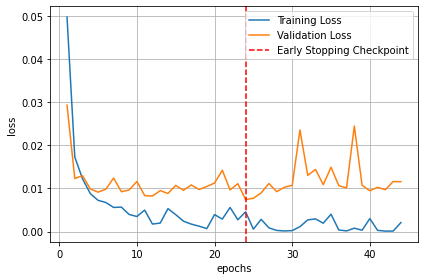

In [21]:
result_plot(train_loss, valid_loss)

### Проверим качество работы нашей инс на тестовой выборке

In [22]:
test_loss = 0
accuracy = 0
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(56):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(3):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.016985

Test Accuracy of     0: 99% (867/875)
Test Accuracy of     1: 99% (884/885)
Test Accuracy of     2: 100% (872/872)

Test Accuracy (Overall): 99% (2623/2632)


### Визуализуем результаты работы инс на тестовой выборке 


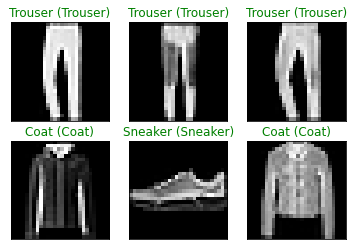

In [23]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure()
for idx in np.arange(6):
    ax = fig.add_subplot(2, 3, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(output_mapping[preds[idx].item()], output_mapping[labels[idx].item()]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## Создание CNN сети 

In [24]:
class ModelCNN(nn.Module):
    """Класс сверточной нейронной сети"""
    def __init__(self):
        super(ModelCNN, self).__init__()
        
        self.layer_1 = nn.Sequential(
                       nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                       nn.BatchNorm2d(32), 
                       nn.ReLU(),
                       nn.MaxPool2d(kernel_size=2, stride=2)) 
        
        self.layer_2 = nn.Sequential(
                       nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                       nn.BatchNorm2d(64),
                       nn.ReLU(),
                       nn.MaxPool2d(2))
        
        self.fc_1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.2)
        self.fc_2 = nn.Linear(in_features=600, out_features=120)
        self.fc_3 = nn.Linear(in_features=120, out_features=10)
        self.drop = nn.Dropout2d(0.2)
        self.fc_4 = nn.Linear(in_features=10, out_features=3)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = x.view(x.size(0), -1)
        x = self.fc_1(x)
        x = self.fc_2(x)
        x = self.fc_3(x)
        x = self.fc_4(x)
        return F.log_softmax(x, dim=1)

In [25]:
fashion_cnn = ModelCNN()
fashion_cnn.to(device) 
criterion = nn.NLLLoss()

learning_rate = 0.001
optimizer = optim.Adam(fashion_cnn.parameters(), lr=learning_rate)
print(fashion_cnn)

ModelCNN(
  (layer_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc_2): Linear(in_features=600, out_features=120, bias=True)
  (fc_3): Linear(in_features=120, out_features=10, bias=True)
  (fc_4): Linear(in_features=10, out_features=3, bias=True)
)


### Обучим нашу нейронную сеть

In [26]:
epochs = 10 
trainer =  create_supervised_trainer(fashion_cnn, optimizer, criterion, device=device)
metrics = {
    'accuracy':Accuracy(),
    'nll':Loss(criterion)
}
train_evaluator = create_supervised_evaluator(fashion_cnn, metrics=metrics, device=device) 
# valid_evaluator = create_supervised_evaluator(fashion_cnn, metrics=metrics, device=device) 

In [27]:
test_evaluator = create_supervised_evaluator(fashion_cnn, metrics=metrics, device=device)
# valid_history = {'accuracy':[], 'loss':[]} 
training_history = test_history = {'accuracy':[], 'loss':[]} 
last_epoch = [] 

In [28]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss') 

In [29]:
def find_score_func(engine):
    """ Функция оценки модели"""
    test_loss = engine.state.metrics['nll']
    return -test_loss

### Реализуем технику ранней остановки для обучения

In [30]:
handler = ignite.handlers.EarlyStopping(patience=3, score_function=find_score_func, trainer=trainer)
# valid_evaluator.add_event_handler(Events.COMPLETED, handler)
test_evaluator.add_event_handler(Events.COMPLETED, handler)

### Реализуем функции, которые будут выполняться в конце каждой эпохи

In [31]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  accuracy: {:.2f} loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))
    

# @trainer.on(Events.EPOCH_COMPLETED)    
# def log_validation_results(trainer):
#     valid_evaluator.run(valid_loader)
#     metrics = valid_evaluator.state.metrics
#     accuracy = metrics['accuracy']*100
#     loss = metrics['nll']
#     valid_history['accuracy'].append(accuracy)
#     valid_history['loss'].append(loss)
#     print("Validation Results - Epoch: {}  accuracy: {:.2f} loss: {:.2f}"
#           .format(trainer.state.epoch, accuracy, loss))
    
def log_testing_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Testing Results - Epoch: {}  accuracy: {:.2f} loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_testing_results) 

In [32]:
trainer.run(train_loader, max_epochs=epochs) 

Training Results - Epoch: 1  accuracy: 99.40 loss: 0.02
Testing Results - Epoch: 1  accuracy: 99.27 loss: 0.02
Training Results - Epoch: 2  accuracy: 99.40 loss: 0.02
Testing Results - Epoch: 2  accuracy: 99.00 loss: 0.03
Training Results - Epoch: 3  accuracy: 99.43 loss: 0.02
Testing Results - Epoch: 3  accuracy: 99.10 loss: 0.03
Training Results - Epoch: 4  accuracy: 99.02 loss: 0.03


2022-02-21 03:05:56,245 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Testing Results - Epoch: 4  accuracy: 98.73 loss: 0.05


State:
	iteration: 788
	epoch: 4
	epoch_length: 197
	max_epochs: 10
	output: 0.004089293070137501
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>